In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
# Join entre Stress e Feedbacks

feedbacks = pd.read_csv("Feedbacks_1109 - feedbacks.csv", parse_dates=['created_date'])
stress = pd.read_csv("Feedbacks_1109 - stress.csv", parse_dates=['created_date'])

stress_sid = stress[pd.notna(stress['session_id'])] # pega os que tem session_id preenchido
stress_email = stress[pd.notna(stress['email'])] # pega os que tem email preenchido
stress_email = stress_email[ ~stress_email['session_id'].isin(stress_sid['session_id']) ] # pega os que tem email sem session_id
stress_final = pd.concat([stress_sid, stress_email])

feedbacks_stress = pd.merge(feedbacks, stress_final, on=['session_id', 'email'], how='inner')
feedbacks_stress.drop(columns = ['created_date_y', 'num_sessao_y'], inplace=True)
feedbacks_stress.rename(index=str, columns={'created_date_x':'created_date', 'num_sessao_x':'num_sessao', 'id_x':'id', 'justificativa_x':'justificativa'}, inplace=True)

feedbacks_stress = feedbacks_stress.loc[feedbacks_stress['num_video_preferido'] > 0]

In [7]:
#normaliza os dados da versao 1 para range de 5
def normalize_v1(feedbacks):
    feedbacks.loc[feedbacks['versao'] == 1, ['incomodo', 'interesse1', 'interesse2'] ] //= 2
    return feedbacks

feedbacks_stress = normalize_v1(feedbacks_stress)

In [8]:
# inversao dos valores das sessoes que tem o primeiro video com QoS alta

def swap_ints(feedbacks):
    feedbacks = feedbacks.reset_index(drop=True)

    for i in range(len(feedbacks.index)):
        if feedbacks.loc[i, 'created_date'].month < 7:
            if feedbacks.loc[i]['num_sessao'] in (1, 3, 6):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']
                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1                   
        else:

            if feedbacks.loc[i, 'num_sessao'] in (1, 5):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']

                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1
    return feedbacks

feedbacks_stress = swap_ints(feedbacks_stress)

In [70]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X = np.array([ feedbacks_stress['interesse1'], feedbacks_stress['interesse2'],
              feedbacks_stress['incomodo'], feedbacks_stress['mais'], feedbacks_stress['interessante'],
              feedbacks_stress['conteúdo'], feedbacks_stress['não'], feedbacks_stress['qualidade'], feedbacks_stress['falhas']
             ]).transpose()


# X = np.array([ normalized_df['interesse1'], normalized_df['interesse2'], normalized_df['incomodo'] ]).transpose()
y = feedbacks_stress['num_video_preferido']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

clf = svm.SVC()
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

accuracy_score(y_test, y_predicted)


KeyError: 'mais'

0.9102244389027432


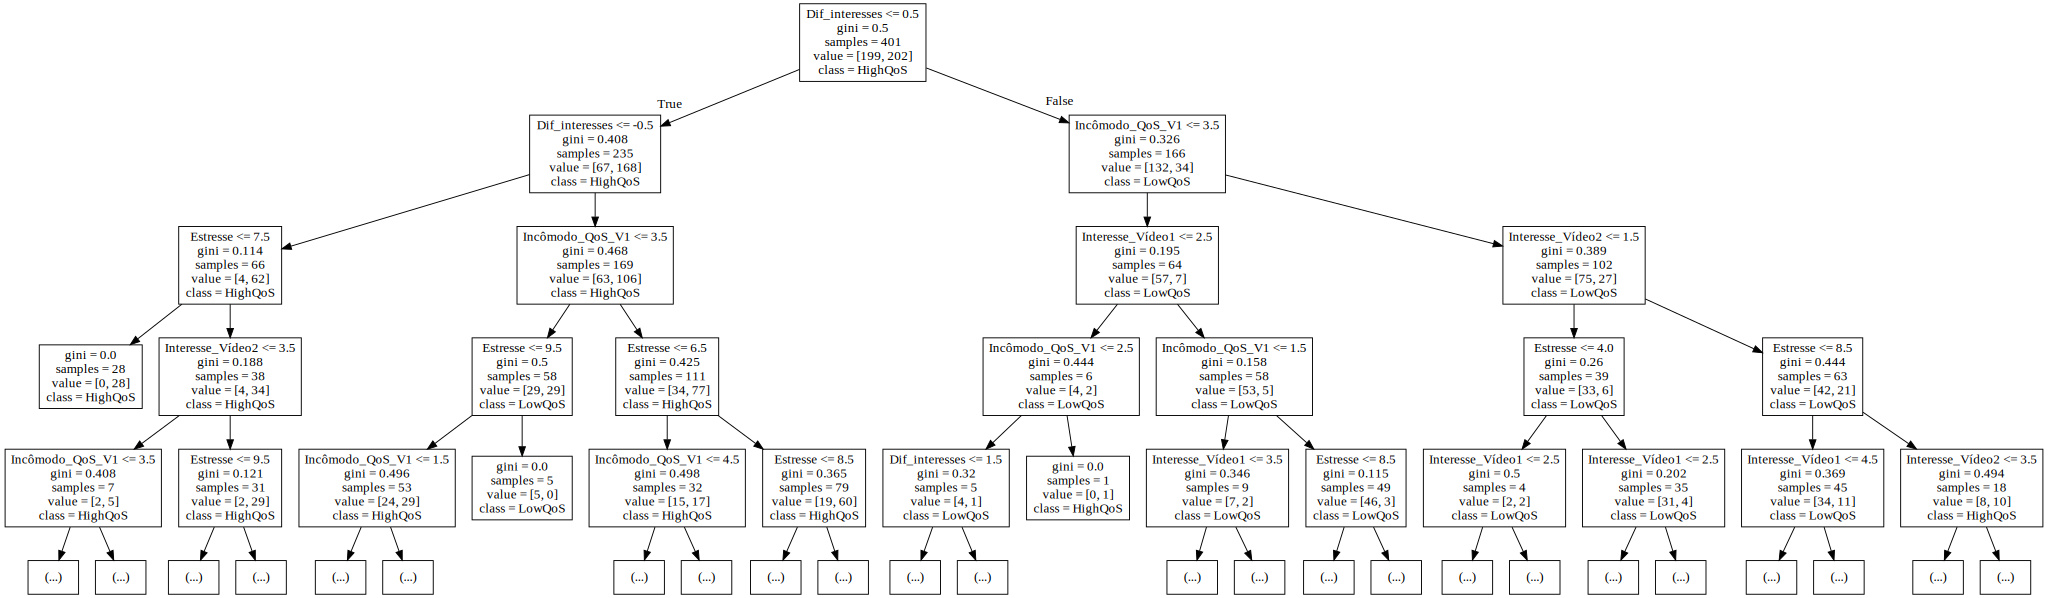

In [6]:
#Arvore de decisao
def arvore(feedbacks, features = ['incomodo', 'interesse1', 'interesse2', 'dif_interesses'],
           feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses'],
           stress=False):
    
#     clf = tree.DecisionTreeClassifier(min_samples_leaf=38)
    clf = tree.DecisionTreeClassifier()
    
    X = []
    for feature in features:
        X.append(feedbacks[feature])
    X = np.array(X).transpose()

    if stress:
        feature_names.append('Estresse')
        X = np.append(X, np.array(feedbacks['estresse']).reshape(-1, 1), axis=1)
        
    Y = np.array(feedbacks['num_video_preferido'])
       
        
    clf.fit(X, Y)
    
    predicted = clf.predict(X)
    print(accuracy_score(Y, predicted))
    
    dot_data = tree.export_graphviz(clf,
                                    feature_names=feature_names,
                                    max_depth=4,
                                    class_names=['LowQoS', 'HighQoS'],
                                    out_file=None) 
    graph = graphviz.Source(dot_data)
#     graph.render("arvore_0108_musica")
    return graph



graph = arvore(feedbacks_stress, stress=True)

graph

In [44]:
# Analisando categoria dos videos(nao confundir com as reportadas pelos usuarios)

# feeds = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
# feeds = normalize_v1(feeds)
# feeds = swap_ints(feeds)

feeds = feedbacks_stress

feeds_per_session_v1 = []
feeds_per_session_v2 = []
for i in range(1, 8):
    f = feeds[feeds['num_sessao'] == i]
    feeds_per_session_v1.append(f[f['created_date'].dt.month < 7])
    feeds_per_session_v2.append(f[f['created_date'].dt.month >= 7])


#Esportes (V1: S1 + S5 ; V2: 1 + 4)
# feeds_esportes = pd.concat([feeds_per_session_v1[0], feeds_per_session_v1[4], feeds_per_session_v2[0], feeds_per_session_v2[3]])
# arvore(feeds_esportes, stress=True)

# Comedia (V1: 2; V2: 2)
# feeds_comedia = pd.concat([feeds_per_session_v1[1], feeds_per_session_v2[1]])
# arvore(feeds_comedia, stress=True)

# Animais (V1: 4, 6; V2: 3, 5)
# feeds_animais = pd.concat([feeds_per_session_v1[3], feeds_per_session_v1[5], 
#                             feeds_per_session_v2[2], feeds_per_session_v2[4]])
# arvore(feeds_animais, stress=True)

# Documentario(V1: 6, 7; V2: 5, 6 )
# feeds_docs = pd.concat([feeds_per_session_v1[5], feeds_per_session_v1[6], 
#                             feeds_per_session_v2[4], feeds_per_session_v2[5]])
# arvore(feeds_docs, stress=True)

# # Musica (V2 apenas: S7)
# feeds_musica = feeds_per_session_v2[6]
# arvore(feeds_musica, stress=True)

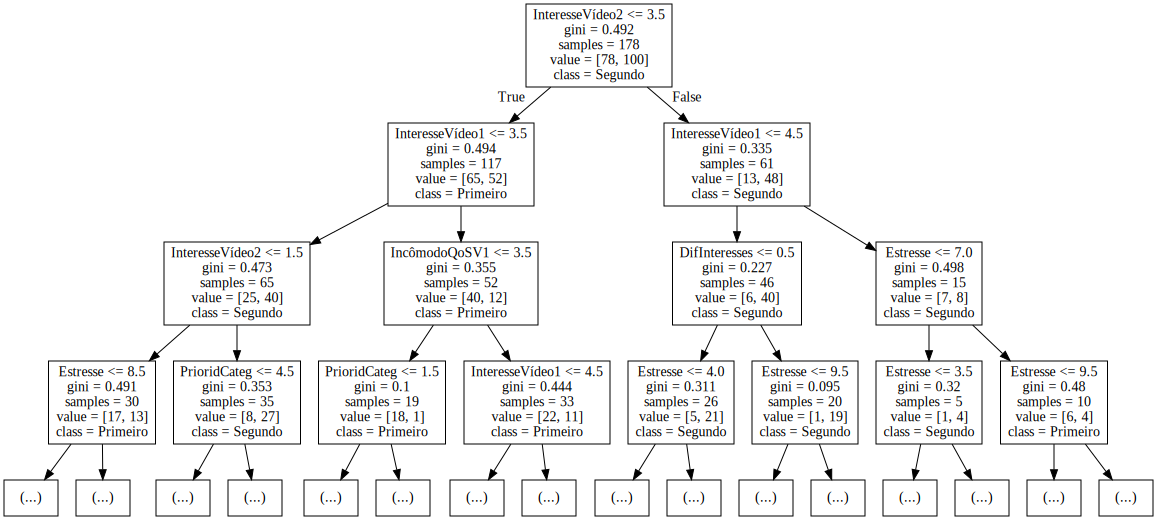

In [51]:
# Analisando as categorias <reportadas> pelos usuários

categories = pd.read_csv("Categorias 01_08 - video_sessions_categories.csv", parse_dates=['created_date'])


categories_sid = categories[pd.notna(categories['session_id'])]

feeds_categ = pd.merge(feedbacks_stress, categories_sid, on='session_id', how='inner') #join
feeds_categ = feeds_categ.reset_index(drop=True)
feeds_categ['categoria_pos'] = np.zeros(len(feeds_categ))

for i in range(len(feeds_categ)):
    f = feeds_categ.iloc[i]
    categs = f.loc[['comedia', 'esporte', 'documentario', 'musica', 'animais']]
    
    categ_sessao = -1
    for j in range(1, 8):
        
        if f['num_sessao'] == 1:
            categ_sessao = 'esporte'
        elif f['num_sessao'] == 2:
            categ_sessao = 'comedia'
        elif f['num_sessao'] == 3:
            categ_sessao = 'animais'
        elif f['num_sessao'] == 4:
            categ_sessao = 'esporte'
        elif f['num_sessao'] == 5:
            categ_sessao = 'documentario'
        elif f['num_sessao'] == 6:
            categ_sessao = 'documentario'
        elif f['num_sessao'] == 7:
            categ_sessao = 'musica'
            
    feeds_categ.at[i, 'categoria_pos'] = categs[categ_sessao]

    
feedbacks = feeds_categ
clf = tree.DecisionTreeClassifier()

feedbacks['dif_interesses'] = abs(feedbacks['interesse1'] - feedbacks['interesse2'])

X = np.array([feedbacks['incomodo'], feedbacks['interesse1'], feedbacks['interesse2'],
              feedbacks['dif_interesses'], feedbacks['estresse'], feedbacks['categoria_pos'] ]).transpose()

Y = np.array(feedbacks['num_video_preferido'])


clf.fit(X, Y)

feature_names = ['IncômodoQoSV1', 'InteresseVídeo1', 'InteresseVídeo2',
                 'DifInteresses', 'Estresse','PrioridCateg']
dot_data = tree.export_graphviz(clf, max_depth=3, feature_names=feature_names,
                                            class_names=['Primeiro', 'Segundo'],out_file=None) 
graph = graphviz.Source(dot_data)
# graph.render("arvore_prior_categ_0108")
graph


In [8]:
# revertendo a troca das classificacoes para solucionar o problema: (j1, primeiro) -> (j1, segundo)

# feeds = pd.read_csv("Feedbacks 01_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
feeds = feedbacks_stress.copy()

f_v1 = feeds[ feeds['created_date'].dt.month < 7]
f_v2 = feeds[ feeds['created_date'].dt.month >= 7]

highQoS = f_v1[ ( f_v1['num_sessao'].isin([1,3,6]) & (f_v1['num_video_preferido']==1) ) |
               (f_v1['num_sessao'].isin([2,4,5,7]) & (f_v1['num_video_preferido']==2) ) ]

highQoS = pd.concat([ highQoS, 
                    f_v2[( f_v2['num_sessao'].isin([1,5]) & (f_v2['num_video_preferido']==1) ) |
                    ( f_v2['num_sessao'].isin([2,3,4,6,7]) & (f_v2['num_video_preferido']==2) )]
                    ])

lowQoS = feeds[~feeds['id'].isin(highQoS['id'])]

lowQoS['class'] = 'lowQoS'
highQoS['class'] = 'highQoS'

low_high = pd.concat([lowQoS, highQoS])
low_high.describe()

low_high = swap_ints(low_high)
low_high.describe()

,id,num_sessao,incomodo,interesse1,interesse2,english_x,num_video_preferido,versao,id_y,estresse,english_y,dif_interesses
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,400.00000,401.000000,401.000000,401.000000,401.000000
mean,248.072319,4.109726,3.690773,3.104738,2.827930,0.029925,1.453865,1.91000,101.578554,7.087282,0.029925,0.576060
std,128.148087,2.064686,1.262592,1.487952,1.512553,0.170594,0.498489,0.28654,64.385980,2.348375,0.170594,1.623215
min,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,-5.000000
25%,139.000000,2.000000,3.000000,2.000000,2.000000,0.000000,1.000000,2.00000,44.000000,6.000000,0.000000,0.000000
50%,248.000000,4.000000,4.000000,3.000000,3.000000,0.000000,1.000000,2.00000,100.000000,8.000000,0.000000,0.000000
75%,359.000000,6.000000,5.000000,4.000000,4.000000,0.000000,2.000000,2.00000,161.000000,9.000000,0.000000,2.000000
max,477.000000,7.000000,5.000000,5.000000,5.000000,1.000000,2.000000,2.00000,208.000000,10.000000,1.000000,5.000000


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
justific = feedbacks_stress[ ['justificativa', 'num_video_preferido'] ].copy()
justific.dropna(inplace=True)
justificativas = justific['justificativa']
# justificativas = justific[justific['num_video_preferido']==2]['justificativa']
# justificativas = lowQoS['justificativa'].dropna()
X = vectorizer.fit_transform(justificativas)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
print(sorted(words_freq, key = lambda x: x[1], reverse=True)[:20])


# # Create the wordcloud object
# wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(justific[justific['num_video_preferido'] == 2]['justificativa_x']))
 
# # Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

[('mais', 108), ('de', 83), ('vídeo', 76), ('não', 70), ('do', 64), ('que', 56), ('qualidade', 52), ('porque', 50), ('falhas', 46), ('interessante', 33), ('segundo', 33), ('no', 32), ('interrupções', 31), ('da', 31), ('as', 28), ('sem', 28), ('melhor', 27), ('em', 26), ('conteúdo', 26), ('primeiro', 24)]


In [7]:
# adiciona colunas das top palavras(palavras mais frequentes para cada classe(highqos e lowqos))

# top words low quality
feedbacks_stress['mais'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['interessante'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['conteúdo'] = np.zeros(len(feedbacks_stress))

# top words high quality
feedbacks_stress['não'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['qualidade'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['falhas'] = np.zeros(len(feedbacks_stress))

In [22]:
# mutual information
from math import log

def count_doc_freq_series(word, s):
    return sum(1 for i in range(len(s)) if word in s.iloc[i].split())

def mutual_info(t, corpus_class, class_name, c1_name, c2_name, ctxt_name):
    c1 = corpus_class[ corpus_class[class_name] == c1_name]
    c2 = corpus_class[ corpus_class[class_name] == c2_name]
    
    corpus_c1 = " ".join(c1[ctxt_name]).lower().replace("\n", "")
    corpus_c2 = " ".join(c2[ctxt_name]).lower().replace("\n", "")
    n = len(corpus_class)
    n_1 = len(c1)
    n_0 = len(c2)
    n11 = count_doc_freq_series(t, c1['justificativa']) # num de documentos da classe v1 que tem o termo t1
    n10 = count_doc_freq_series(t, c2['justificativa']) # num de documentos que nao sao da classe v1 que tem o termo t1
    if (n11==0 or n10==0):
        return 0
    n01 = n_1 - n11 # num documentos da classe v1 que nao tem o termo t1
    n00 = n_0 - n10 # num documentos que nao sao da classe v1 e nao tem o termo t1
    n1_ = n11 + n10 # num documentos que tem o t1
    n0_ = n01 + n00 # num documentos que nao tem o termo t1
    
#     print("et=1 ec=1 ", n11)
#     print("et=1 ec=0 ", n10)
#     print("et=0 ec=1", n01)
#     print("et=0 ec=0", n00)
    
    I = ( n11/n * log((n*n11)/(n1_*n_1), 2) ) + ( n01/n * log((n*n01)/(n0_*n_1), 2) ) + \
    ( n10/n * log(n*n10/(n1_*n_0), 2) ) + ( n00/n*log(n*n00/(n0_*n_0), 2) )
    
    return I

# justificativa_low_high = low_high[ ['justificativa', 'class'] ]
# justificativa_low_high = justificativa_low_high.dropna()
t1 = "não"
t2 = "qualidade"
t3 = "falhas"

print(mutual_info(t1, justific, 'num_video_preferido', 2, 1, 'justificativa'))
# print(mutual_info(t, justificativa_low_high, 'class', 'lowQoS', 'highQoS', 'justificativa'))


0.04512022050385898


In [23]:
corpus = justific['justificativa']
corpus = " ".join(corpus).lower().replace("\n", "")
corpus = corpus.split()
corpus = list(set(corpus))

words_mi = {}
for i in corpus:
    words_mi[i] = mutual_info(i, justific, 'num_video_preferido', 1, 2, 'justificativa')
#     print(i+': '+str(mutual_info(i, justific, 'num_video_preferido', 1, 2, 'justificativa')))

sorted(words_mi.items(), key=lambda x:x[1], reverse=True)


[('qualidade', 0.051401300994168404),
 ('não', 0.04512022050385897),
 ('sem', 0.03616175635482347),
 ('mais', 0.03536830911857876),
 ('falhas', 0.03535174265209461),
 ('imagem', 0.024068459477133364),
 ('da', 0.02277356775167494),
 ('teve', 0.016347541436718488),
 ('mas', 0.012661235081492918),
 ('conteúdo', 0.012550208473037547),
 ('interrupção', 0.01177329888950207),
 ('de', 0.010546302990397764),
 ('interesse', 0.010336648891771721),
 ('as', 0.01031454298370458),
 ('no', 0.009614883590601957),
 ('música', 0.009577665655103903),
 ('interrupções.', 0.009577665655103903),
 ('interrupções', 0.00842469794040442),
 ('eram', 0.008092826595913982),
 ('o', 0.007936616252303602),
 ('menos', 0.007462081758129433),
 ('muito', 0.006455717722809028),
 ('é', 0.006166585984341361),
 ('tema', 0.006128047585617358),
 ('ser', 0.006128047585617358),
 ('engraçado', 0.0059531295449717315),
 ('foi', 0.005709804828241969),
 ('a', 0.005448195508388806),
 ('bem', 0.005005850760571514),
 ('primeiro', 0.004913

In [11]:
# insere os valores de informacao mutua

index = feedbacks_stress['justificativa'].dropna().index

for i in index:
    
    if feedbacks_stress.loc[i]['num_video_preferido'] == 1:
        if 'mais' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'mais'] = mutual_info('mais', justific, 'num_video_preferido', 1, 2, 'justificativa')
        elif 'interessante' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'interessante'] = mutual_info('interessante', justific, 'num_video_preferido', 1, 2, 'justificativa')
        elif 'conteúdo' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'conteúdo'] = mutual_info('conteúdo', justific, 'num_video_preferido', 1, 2, 'justificativa')

    else:
        if 'não' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'não'] = mutual_info('não', justific, 'num_video_preferido', 2, 1, 'justificativa')
        elif 'qualidade' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'qualidade'] = mutual_info('qualidade', justific, 'num_video_preferido', 2, 1, 'justificativa')
        elif 'falhas' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'falhas'] = mutual_info('falhas', justific, 'num_video_preferido', 2, 1, 'justificativa')
        

0.9152119700748129


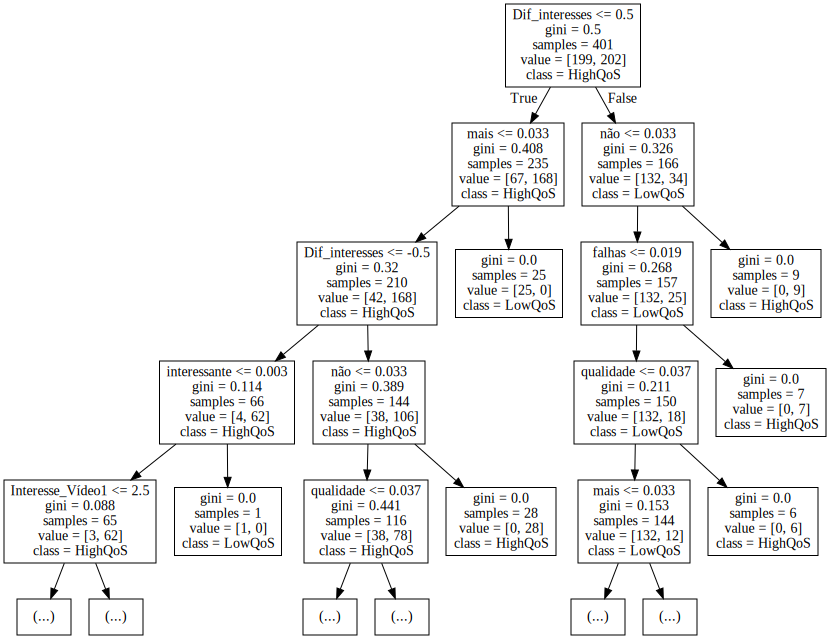

In [14]:
graph = arvore(feedbacks_stress, features = ['incomodo', 'interesse1', 'interesse2', 'dif_interesses', 'mais', 'interessante', 'conteúdo', 'não', 'qualidade', 'falhas'],
           feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses', 'mais', 'interessante', 'conteúdo', 'não', 'qualidade', 'falhas'])
graph

In [18]:
df_sessions = []
for i in range(1, 8):
    if i == 1:
        categ_sessao = 'esporte'
    elif i == 2:
        categ_sessao = 'comedia'
    elif i == 3:
        categ_sessao = 'animais'
    elif i == 4:
        categ_sessao = 'esporte'
    elif i == 5:
        categ_sessao = 'documentario'
    elif i == 6:
        categ_sessao = 'documentario'
    elif i == 7:
        categ_sessao = 'musica'
    print(categ_sessao + "\n")
    print(feedbacks_stress[ feedbacks_stress['num_sessao'] == i ][['num_video_preferido', 'incomodo', 'interesse1', 'interesse2']].describe())
    print("\n")

esporte

       num_video_preferido   incomodo  interesse1  interesse2
count            58.000000  58.000000   58.000000   58.000000
mean              1.551724   3.948276    2.948276    2.310345
std               0.501661   1.066597    1.648204    1.569522
min               1.000000   1.000000    0.000000    0.000000
25%               1.000000   3.000000    2.000000    1.000000
50%               2.000000   4.000000    3.000000    2.000000
75%               2.000000   5.000000    4.000000    4.000000
max               2.000000   5.000000    5.000000    5.000000


comedia

       num_video_preferido   incomodo  interesse1  interesse2
count            44.000000  44.000000   44.000000   44.000000
mean              1.545455   3.795455    3.250000    2.954545
std               0.503686   1.304367    1.366118    1.461992
min               1.000000   0.000000    0.000000    0.000000
25%               1.000000   3.000000    2.750000    2.000000
50%               2.000000   4.000000    3.000000 

In [69]:
# Gradient boosting algorithms
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

feedbacks_stress['dif_interesses'] = abs(feedbacks_stress['interesse1'] - feedbacks_stress['interesse2'])


X = np.array([ feedbacks_stress['interesse1'], feedbacks_stress['interesse2'], feedbacks_stress['dif_interesses'],
              feedbacks_stress['incomodo'], feedbacks_stress['estresse'] ]).transpose()
y = feedbacks_stress['num_video_preferido']


clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(clf, X, y)
scores.mean()       

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
     max_depth=5, random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))
scores = cross_val_score(clf, X, y)
print(scores.mean())

print(clf.feature_importances_)

0.6986301369863014
0.6185336976320582
[0.12659928 0.15668324 0.16013405 0.2085605  0.34802292]


In [71]:
def gaussian_func(points, use_z = False):
    mu = np.mean(points)
    std = np.std(points)
    
    if use_z:
        z_points = (points - mu) / std
        y_gauss = 1/(np.sqrt(2 * np.pi)) * np.e**(-0.5 * z_points**2)
        return z_points, y_gauss
    else:
        y_gauss = ( 1/(std * np.sqrt(2 * np.pi)) ) * np.e**(-(points-mu)**2/std**2)
        return points, y_gauss

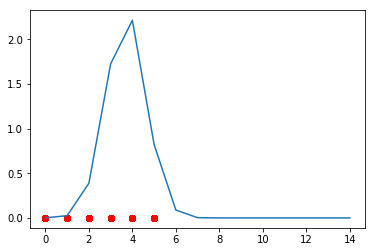

In [72]:
def gauss_value(points, mu, std):
    y_gauss = ( (1/std* np.sqrt(2**np.pi)) ) * np.e**(-(points-mu)**2/std**2)
    return y_gauss

incomodo = np.array(feedbacks_stress['incomodo'])
x_points = np.sort(incomodo)

# points, y_gauss = gaussian_func(x_points, use_z=False)

mean = np.mean(incomodo)
std = np.std(incomodo)

x_base = np.arange(0, 15)
y_gauss = gauss_value(x_base, mean, std)

plt.plot(incomodo, np.zeros(len(incomodo)), 'ro')
plt.plot(x_base, y_gauss)

In [73]:
def grid_search_mu_std(array):

    mu_range = np.arange(1, 10, 0.1)
    std_range = np.arange(1, 10, 0.1)

    best_mu = -np.inf
    best_std = -np.inf
    max_likelihood = -np.inf


    for mu_t in mu_range:
        for std_t in std_range:
            y_gauss = gauss_value(array, mu_t, std_t)
            log_likelihood = np.sum(np.log(y_gauss))
            if (log_likelihood - max_likelihood) > 0.00001:
                max_likelihood = log_likelihood
                best_mu = mu_t
                best_std = std_t
    print("Melhor média: ", best_mu)
    print("Melhor std: ", best_std)
    return best_mu, best_std

dif_ints = feedbacks_stress['dif_interesses']
incomodo = feedbacks_stress['incomodo']

Melhor média:  7.2000000000000055
Melhor std:  3.300000000000002


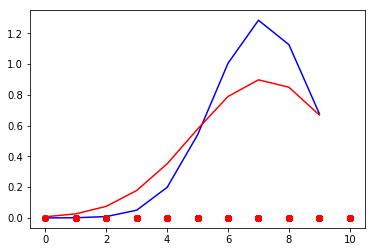

In [74]:
def plot_normal(array):

    mean_a = np.mean(array)
    std_a = np.std(array)

    x_base = np.arange(0, 10)
    y_gauss_inc = gauss_value(x_base, mean_a, std_a)

    mean_opt, std_opt = grid_search_mu_std(array)

    y_gauss_opt = gauss_value(x_base, mean_opt, std_opt)

    plt.plot(x_base, y_gauss_inc, 'b')
    plt.plot(array, np.zeros(len(array)), 'ro')
    plt.plot(x_base, y_gauss_opt, 'r')

# plot_normal(incomodo)
# plot_normal(dif_ints)
# plot_normal(feedbacks_stress['interesse1'])
# plot_normal(feedbacks_stress['interesse2'])
plot_normal(feedbacks_stress['estresse'])

In [224]:
# prepara para aplicar os algoritmos de ML

label = feedbacks_stress.num_video_preferido
label = label.astype('int').reshape(-1,1)


feedbacks_stress_text = feedbacks_stress.drop(['id', 'email','num_sessao','num_video_preferido', 'created_date', 'comment','published_date', 'english', 'session_id','versao'], axis=1)
feedbacks_stress = feedbacks_stress_text.drop(['justificativa'], axis=1)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,id,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,english,versao,estresse
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,163.250000,4.129032,1.451613,7.334677,6.193548,5.302419,0.012097,1.854839,6.806452
std,77.268827,2.057740,0.498660,2.510885,2.935687,3.039763,0.109539,0.352976,2.413449
min,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,101.750000,2.000000,1.000000,6.000000,4.000000,2.000000,0.000000,2.000000,5.000000
50%,162.500000,4.000000,1.000000,8.000000,6.000000,6.000000,0.000000,2.000000,7.000000
75%,233.250000,6.000000,2.000000,10.000000,8.000000,8.000000,0.000000,2.000000,8.000000
max,295.000000,7.000000,2.000000,10.000000,10.000000,10.000000,1.000000,2.000000,10.000000


In [225]:
class Results:
    def __init__(self):
        pass
    nb = []
    tree = []
    sgd = []
    lsvc = []
    svc = []
    kmeans = []
    knn = []
    rf = []
    mlp = []
    
def run_algorithms(results, df_data, label):
    #Initialize test and train data
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    x_train, x_test, y_train, y_test = train_test_split(df_data, label, test_size=0.3)
    
    #Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    nb_clf = MultinomialNB().fit(x_train, y_train)
    nb_y_pred = nb_clf.predict(x_test)
    nb_cm = confusion_matrix(y_test, nb_y_pred)
    nb_p1 = precision_score(y_test, nb_y_pred)
    nb_p2 = precision_score(y_test, nb_y_pred, pos_label=2)
    nb_p = precision_score(y_test, nb_y_pred, average='weighted')
    nb_a = accuracy_score(y_test, nb_y_pred)
    nb_r = classification_report(y_test, nb_y_pred)
    results.nb += [[nb_p1, nb_p2, nb_p, nb_a, nb_cm, nb_r]]
    
    #Decision Trees
    from sklearn import tree
    tree_clf = tree.DecisionTreeClassifier().fit(x_train, y_train)
    tree_y_pred = tree_clf.predict(x_test)
    tree_cm = confusion_matrix(y_test, tree_y_pred)
    tree_p1 = precision_score(y_test, tree_y_pred)
    tree_p2 = precision_score(y_test, tree_y_pred, pos_label=2)
    tree_p = precision_score(y_test, tree_y_pred, average='weighted')
    tree_a = accuracy_score(y_test, tree_y_pred)
    tree_r = classification_report(y_test, tree_y_pred)
    results.tree += [[tree_p1, tree_p2, tree_p, tree_a, tree_cm, tree_r]]
    
    
    #Stochastic Gradient Descent
    from sklearn.linear_model import SGDClassifier
    sgd_clf = SGDClassifier(alpha=.000001, n_iter=50000).fit(x_train, y_train)
    sgd_y_pred = sgd_clf.predict(x_test)
    sgd_cm = confusion_matrix(y_test, sgd_y_pred)
    sgd_p1 = precision_score(y_test, sgd_y_pred)
    sgd_p2 = precision_score(y_test, sgd_y_pred, pos_label=2)
    sgd_p = precision_score(y_test, sgd_y_pred, average='weighted')
    sgd_a = accuracy_score(y_test, sgd_y_pred)
    sgd_r = classification_report(y_test, sgd_y_pred)
    results.sgd += [[sgd_p1, sgd_p2, sgd_p, sgd_a, sgd_cm, sgd_r]]
    
    
    #Linear SVC
    from sklearn.svm import LinearSVC
    lsvc_clf = LinearSVC(dual=False, max_iter=10000, tol=1e-6).fit(x_train, y_train)
    lsvc_y_pred = lsvc_clf.predict(x_test)
    lsvc_cm = confusion_matrix(y_test, lsvc_y_pred)
    lsvc_p1 = precision_score(y_test, lsvc_y_pred)
    lsvc_p2 = precision_score(y_test, lsvc_y_pred, pos_label=2)
    lsvc_p = precision_score(y_test, lsvc_y_pred, average='weighted')
    lsvc_a = accuracy_score(y_test, lsvc_y_pred)
    lsvc_r = classification_report(y_test,lsvc_y_pred)
    results.lsvc += [[lsvc_p1, lsvc_p2, lsvc_p, lsvc_a, lsvc_cm, lsvc_r]]
    
    
    #SVC
    from sklearn.svm import SVC
    svc_clf = SVC(cache_size=2000, probability = True).fit(x_train, y_train)
    svc_y_pred = svc_clf.predict(x_test)
    svc_cm = confusion_matrix(y_test, svc_y_pred)
    svc_p1 = precision_score(y_test, svc_y_pred)
    svc_p2 = precision_score(y_test, svc_y_pred, pos_label=2)
    svc_p = precision_score(y_test, svc_y_pred, average='weighted')
    svc_a = accuracy_score(y_test, svc_y_pred)
    svc_r = classification_report(y_test,svc_y_pred) 
    results.svc += [[svc_p1, svc_p2, svc_p, svc_a, svc_cm, svc_r]]
    

    
    #KNN Classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn_clf = KNeighborsClassifier(n_neighbors=15).fit(x_test, y_test)
    knn_y_pred = knn_clf.predict(x_test)
    knn_cm = confusion_matrix(y_test, knn_y_pred)
    knn_p1 = precision_score(y_test, knn_y_pred)
    knn_p2 = precision_score(y_test, knn_y_pred, pos_label=2)
    knn_p = precision_score(y_test, knn_y_pred, average='weighted')
    knn_a = accuracy_score(y_test, knn_y_pred)
    knn_r = classification_report(y_test, knn_y_pred)
    results.knn += [[knn_p1, knn_p2, knn_p, knn_a, knn_cm, knn_r]]
    
    #Random Forest Algorithm
    from sklearn.ensemble import RandomForestClassifier 
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
    rf_y_pred = rf_clf.predict(x_test)
    rf_cm = confusion_matrix(y_test, rf_y_pred)
    rf_p1 = precision_score(y_test, rf_y_pred)
    rf_p2 = precision_score(y_test, rf_y_pred, pos_label=2)
    rf_p = precision_score(y_test, rf_y_pred, average='weighted')
    rf_a = accuracy_score(y_test, rf_y_pred)
    rf_r = classification_report(y_test, rf_y_pred)
    results.rf += [[rf_p1, rf_p2, rf_p, rf_a, rf_cm, rf_r]]
    
    
    #Neural Network
    from sklearn.neural_network import MLPClassifier
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,150), max_iter=1000).fit(x_train, y_train)
    mlp_y_pred = mlp_clf.predict(x_test)
    mlp_cm = confusion_matrix(y_test, mlp_y_pred)
    mlp_p1 = precision_score(y_test, mlp_y_pred)
    mlp_p2 = precision_score(y_test, mlp_y_pred, pos_label=2)
    mlp_p = precision_score(y_test, mlp_y_pred, average='weighted')
    mlp_a = accuracy_score(y_test, mlp_y_pred)
    mlp_r = classification_report(y_test, mlp_y_pred)
    results.mlp += [[mlp_p1, mlp_p2, mlp_p, mlp_a, mlp_cm, mlp_r]]
    
    return results

def print_results(results):
    #Write to file
    writer = pd.ExcelWriter('output.xlsx')
    df_nb = pd.DataFrame(data=results.nb, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_tree = pd.DataFrame(data=results.tree, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_sgd = pd.DataFrame(data=results.sgd, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_lsvc = pd.DataFrame(data=results.lsvc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_svc = pd.DataFrame(data=results.svc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_knn = pd.DataFrame(data=results.knn, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_rf = pd.DataFrame(data=results.rf, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_mlp = pd.DataFrame(data=results.mlp, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    
    writer = pd.ExcelWriter('output.xlsx')
    df_nb.to_excel(writer,'Naive Bayes')
    df_tree.to_excel(writer,'Decision Tree')
    df_sgd.to_excel(writer,'Stochastic Gradient Descent')
    df_lsvc.to_excel(writer,'Linear SVC')
    df_svc.to_excel(writer,'Support Vector Classification')
    df_knn.to_excel(writer,'K-Nearest Neighbors')
    df_rf.to_excel(writer,'Random Forest')
    df_mlp.to_excel(writer,'Multi Layer Perceptron')

    writer.save()
    

In [226]:
#Main():
container = Results()
for i in range(10):
    container = run_algorithms(container, feedbacks_stress, label)
    
print_results(container)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

In [121]:
a = np.array([0, 1, 2, 0, 1, 5, 3, 3, 2])
b = 

array([0., 0., 0.])